### Подключим необходимые библиотеки

In [1]:
from sklearn.preprocessing import FunctionTransformer

from reskit.norms import binar_norm, wbysqdist
from reskit.norms import spectral_norm

import os
import pandas as pd
import numpy as np

import matrix_eig as me

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def orig(x):
    return x

### Функция считывания данных

In [2]:
def get_autism(path_to_read='../Data/dti/', distances=True):
    def get_autism_distances(loc_name):
        with open(loc_name, 'r') as f:
            read_data = f.readlines()

        read_data = pd.DataFrame(
            np.array([np.array(item[:-1].split()).astype(int) for item in read_data]))

        return read_data

    def get_distance_matrix(coords):
        if type(coords) == pd.core.frame.DataFrame:
            coords = coords.values
        elif type(coords) != np.ndarray:
            print('Provide either pandas df or numpy array!')
            return -1

        shape = len(coords)
        dist_matrix = np.zeros((shape, shape))
        del shape
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                dist_matrix[i, j] = np.linalg.norm(coords[i, :] - coords[j, :])
                dist_matrix[j, i] = dist_matrix[i, j]
        return dist_matrix

    target_vector = []  # this will be a target vector (diagnosis)
    matrices = []  # this will be a list of connectomes
    all_files = sorted(os.listdir(path_to_read))
    matrix_files = [
        item for item in all_files if 'DTI_connectivity' in item and 'All' not in item]
    distance_files = [
        item for item in all_files if 'DTI_region_xyz_centers' in item and 'All' not in item]

    # for each file in a sorted (!) list of files:
    for filename in matrix_files:

        A_dataframe = pd.read_csv(
            path_to_read + filename, sep='   ', header=None, engine='python')
        A = A_dataframe.values  # we will use a list of numpy arrays, NOT pandas dataframes
        matrices.append(A)# append a matrix to our list
        if "ASD" in filename:
            target_vector.append(1)
        elif "TD" in filename:
            target_vector.append(0)
    asd_dict = {}
    asd_dict['X'] = np.array(matrices)
    asd_dict['y'] = np.array(target_vector)
    if distances:
        dist_matrix_list = []
        for item in distance_files:
            # print(item)
            cur_coord = get_autism_distances(path_to_read + item)
            cur_dist_mtx = get_distance_matrix(cur_coord)
            dist_matrix_list += [cur_dist_mtx]

        asd_dict['dist'] = np.array(dist_matrix_list)

    return asd_dict


## Обучим SVM

In [3]:
#Функция понижения размерности (ТОЛЬКО СОБСТВЕННЫЕ ВЕКТОРА)
def matrix_eig(data, k = 250):
    new_data = {}
    new_data['y'] = data['y']
    new_data['X'] = np.zeros(shape = (data['X'].shape[0], data['X'].shape[1], data['X'].shape[1] - k))
    for i in np.arange(data['X'].shape[0]):
        curs, vecs = np.linalg.eig(data['X'][i])
        indeces_del = curs.argsort()[:k]
        vecs_n = np.delete(vecs, indeces_del, axis=1)
        #curs = np.delete(curs, indeces_del)
        new_data['X'][i] = vecs_n
    return orig_vec(new_data)


#Функция, которая в словаре data из матриц X создает вектора X_vec
def orig_vec(data):
    matrix = []
    for i in  data['X']:
        matrix.append(np.hstack(i))
    data['X_vec'] = matrix
    return data

#Функция преобразования матрицы в вектор и наоборот
def convert(A, mode, size = 264):
    if mode == 'mat2vec':
        A_vec = np.hstack(A)
        return A_vec
        
    if mode == 'vec2mat':
        A_mat = []
        i = 0
        while i != A.shape[0]:
            A_str = A[0+i:size+i]
            A_mat.append(A_str)
            i += size
        A_mat = np.vstack(A_mat)
        return A_mat

In [4]:
#Ядро
def ker(A, B):
    #Данные подавются в виде векторов, поэтому преобразуем их в матрицы
    A = convert(A, 'vec2mat')
    B = convert(B, 'vec2mat')
    #Посчитаем расстояние
    d = np.linalg.norm(A.T.dot(B), 'fro') ** 2
    return d * 10 ** -2

def my_kernel(X, Xfit):
    size1 = np.shape(X)[0]
    size2 = np.shape(Xfit)[0]
    dist = np.zeros([size1, size2])
    for i in range(size1):
        for j in range(size2):
            dist[i][j] = ker(X[i], Xfit[j])
    return dist

### Посмотрим на корреляцию объектов

Для ядра между одним классом матрица симметрическая, на диагонали которй стоят единицы.
![mat](https://wikimedia.org/api/rest_v1/media/math/render/svg/a6cf29fde661b627a2071a8ea038b0304d3c6e63)
Изобразим лишь элементы над главной диагональю

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

def print_ker(ker, color):
    y_ker = np.hstack(ker)
    x_ker = np.arange(y_ker.shape[0])
    plt.plot(x_ker, y_ker, color)
    
def meaning(ker):
    if ker.shape[0] == ker.shape[1]:
        rows, cols = np.triu_indices(ker.shape[0],k = 1)
        y_ker = ker[rows,cols]
    else:
        y_ker = np.hstack(ker)
    
    return y_ker[y_ker < 2]
    
def print_kers(kers, hist = True, scater = True):
    if hist:   f1, ax1 = plt.subplots(1, np.size(kers), sharey=True, figsize=(21, 5))
    if scater: f2, ax2 = plt.subplots(1, np.size(kers), sharey=True, figsize=(21, 5))
    for (i,ker) in enumerate(kers):
        y_ker = meaning(ker)
        x_ker = np.arange(y_ker.shape[0])
        if hist:   ax1[i].hist(y_ker)
        if scater: ax2[i].plot(x_ker, y_ker,'bo')

In [6]:
def show_ker(data, k, hist = True, scater = True):
    data_low = matrix_eig(data, k=k)
    #data_low = orig_vec(data)
    X = data_low['X_vec']
    y = data_low['y']

    X_0 = []
    X_1 = []
    for (i, y_i) in enumerate(y):
        if   y_i == 0: X_0.append(X[i])
        elif y_i == 1: X_1.append(X[i])
            
    ker_1_1 = my_kernel(X_1, X_1)
    ker_0_0 = my_kernel(X_0, X_0)
    ker_0_1 = my_kernel(X_0, X_1)
    
    print_kers([ker_0_0, ker_0_1, ker_1_1], hist = hist, scater = scater)

In [7]:
data = get_autism("../Data/dti/")

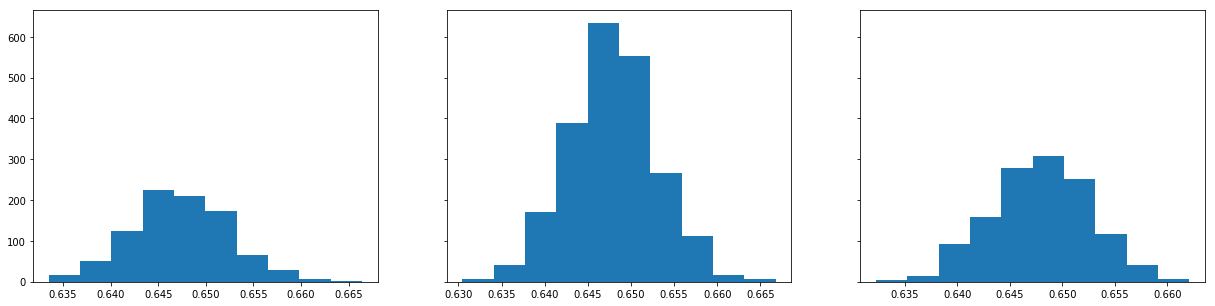

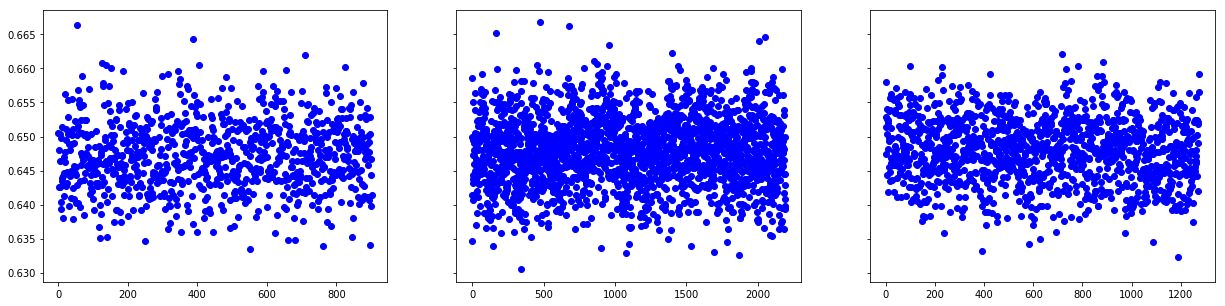

In [8]:
show_ker(data, 200)

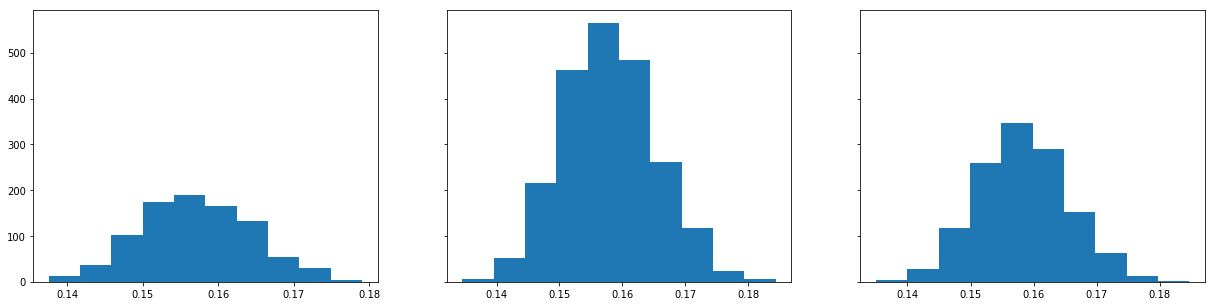

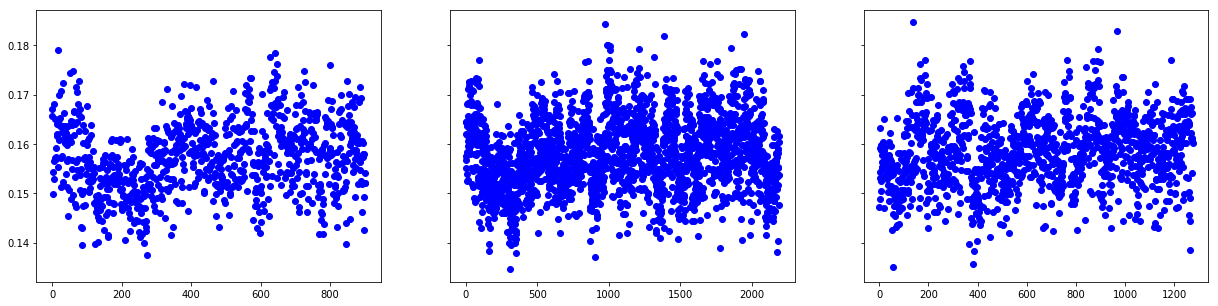

In [9]:
show_ker(data, 250)

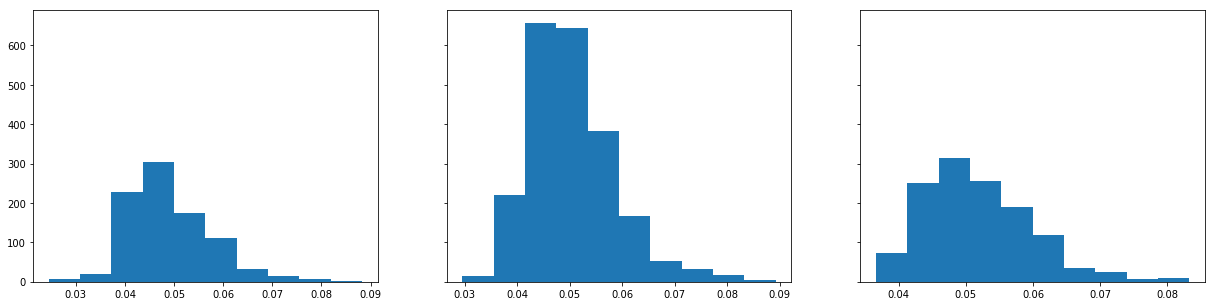

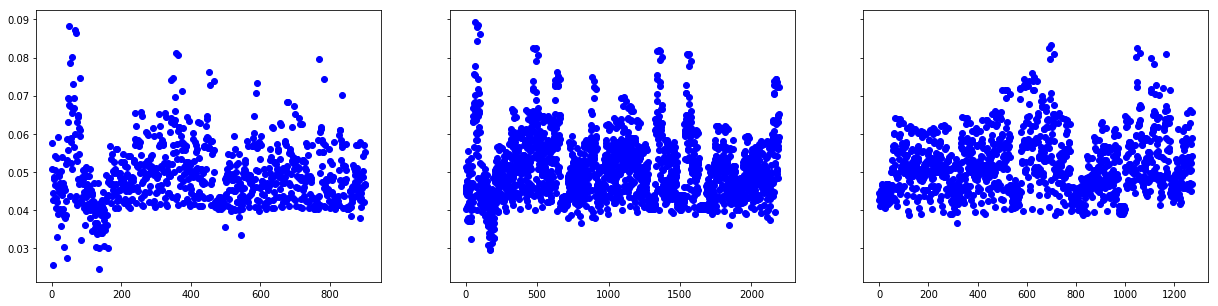

In [10]:
show_ker(data, 260)

In [11]:
data_b = binar_norm(data)

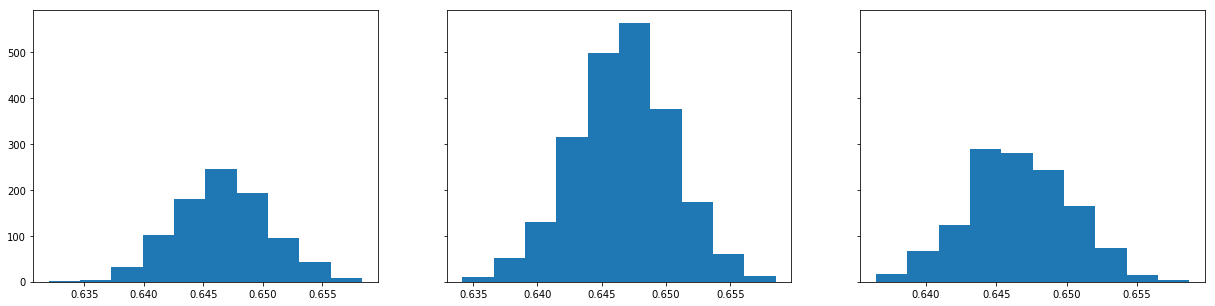

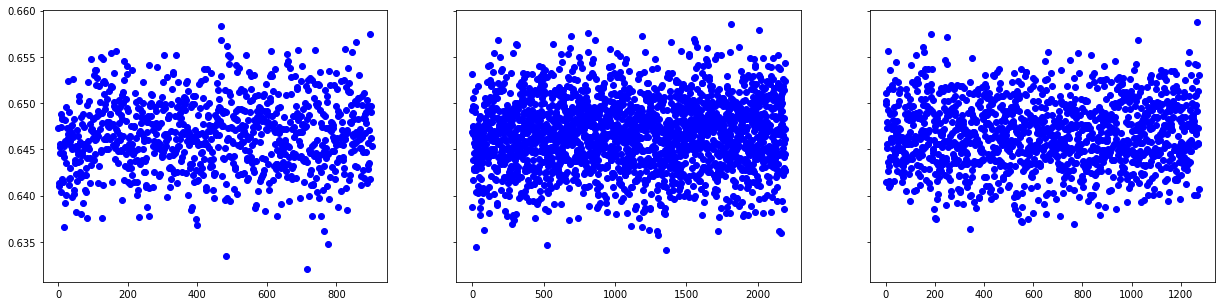

In [12]:
show_ker(data_b, 200)

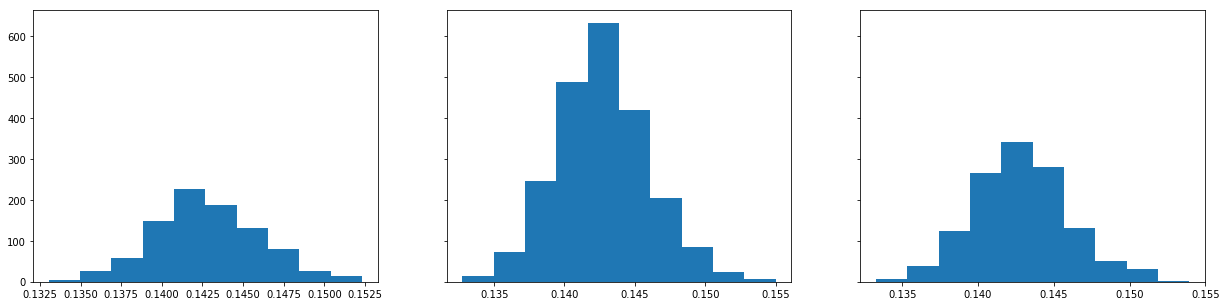

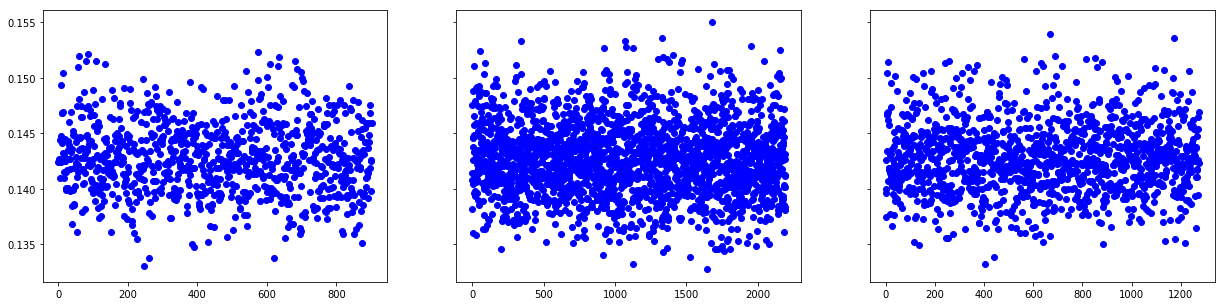

In [13]:
show_ker(data_b, 250)

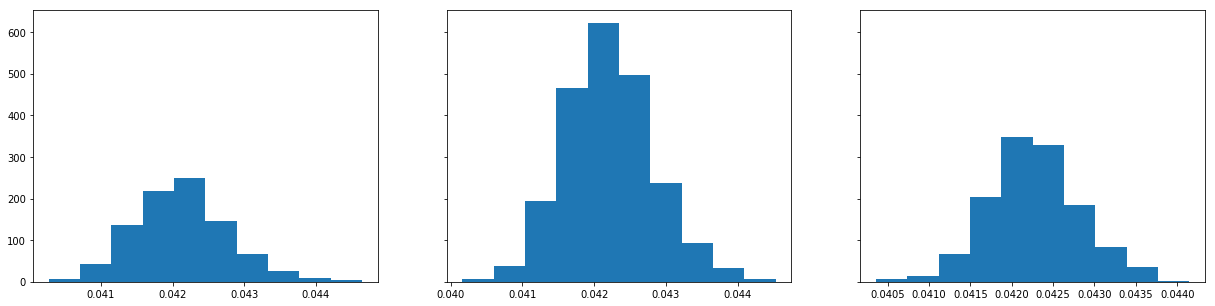

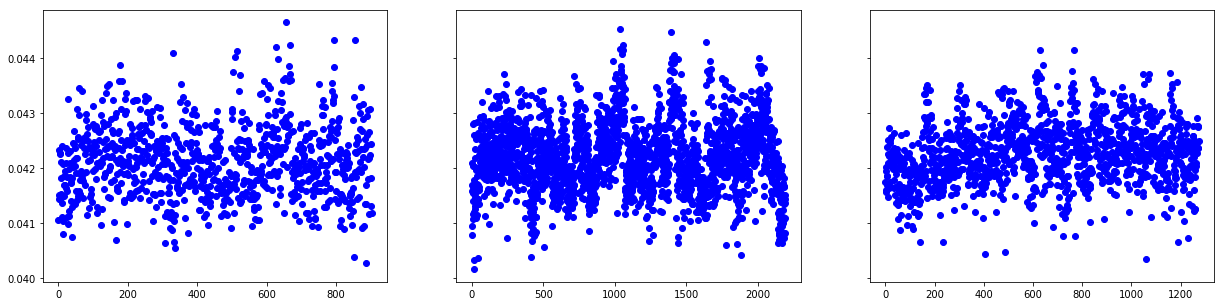

In [14]:
show_ker(data_b, 260)